In [1]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os

In [2]:
RECORDINGS_PATH = "/Users/sptm/dev/personal/beep-detection-dataset/audiofiles"
os.chdir(RECORDINGS_PATH)
df = pd.read_pickle("amd-df.pkl")


#convert label seriers to ints
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['label'])
df['label'] = le.transform(df['label']) 

print("count:")
print(df.label.value_counts())
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)
class_names = le.classes_

df.head()


count:
0    101
1     32
Name: label, dtype: int64
{'beep': 0, 'speech': 1}


,file_path,mfccs_40,chroma,mel,contrast,tonnetz,duration,label
0,beep/overdrive_beep_1000_0.5_1.1.wav,"[-648.7732023402463, 20.740027296822582, -5.91...","[0.7426175694626616, 0.7781152791222149, 0.824...","[0.0026247237229858823, 0.0006950270827125862,...","[56.51764945998396, 16.33025638875271, 16.9291...","[0.007893745237780317, 0.025323062200878606, 0...",5.08,0
2,beep/beep_500_0.5_1.1.wav,"[-480.8374331960098, 10.282236333040958, 3.655...","[0.7520259169180716, 0.7858180386260021, 0.833...","[0.031262080105508704, 0.03167270253963774, 0....","[49.83079341143087, 15.750314235349212, 19.078...","[0.00024741614877230386, 0.03390149680750231, ...",5.06,0
4,beep/beep_1500_0.5_1.2.wav,"[-479.43226392005187, 8.823462420491044, -7.00...","[0.7113293586172407, 0.7758262316678054, 0.829...","[0.007056509943697298, 0.005333584908935328, 0...","[54.4286362849155, 18.782510605942036, 19.1482...","[0.00016978951816631077, 0.02980498970033441, ...",5.04,0
6,beep/whitenoise_beep_1000_1_1.4.wav,"[-510.32630840985456, 116.5288260006204, -61.4...","[0.6301969016301114, 0.6376268612024417, 0.672...","[0.0015886821479110318, 0.0009468671348235026,...","[22.677968639075868, 12.218876538183435, 13.80...","[0.004513859067965158, -0.003625802336170082, ...",5.06,0
8,beep/overdrive_beep_1000_0.2_0.9.wav,"[-633.8929389641592, 13.329635016242825, -1.71...","[0.7774235039606778, 0.8326985399960135, 0.887...","[0.003848214383519196, 0.0009013721193474459, ...","[61.9167246932255, 19.312564563129726, 19.5758...","[0.002519536997647612, 0.0634943357789246, 0.0...",5.06,0


In [3]:
#remove files with durations longer than 10 seconds
df = df.copy()
df = df.drop(df[ df['duration']>10].index)
df.reset_index(drop=True, inplace=True)

print(df.label.value_counts())


0    101
1     32
Name: label, dtype: int64


In [5]:
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
from sklearn.externals import joblib
import datetime
import pickle


def print_classification_results(y_test, res):
    print(metrics.accuracy_score(y_test, res))
    print(metrics.classification_report(y_test, res))
    print(metrics.confusion_matrix(y_test, res))
    print("")

    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def save_model(model, model_name):
  filename = "{}-{}.pkl".format(model_name, datetime.datetime.now().strftime("%Y%m%dT%H%M"))
  pickle.dump(model, open(filename, 'wb'))
  # files.download(filename)
  


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

def generateFeaturesLabels(features_list):
  total_features_len = np.sum([len(df[feature][0]) for feature in features_list])
  print("total number of features",total_features_len)
  features, labels = np.empty((0,total_features_len)), np.empty(0)
  for index, row in df.iterrows():
    a = []
    for feature in features_list:
      a.append(row[feature])
      
    features = np.vstack([features,np.hstack(a)])
    labels = np.append(labels, row["label"])
  return np.array(features), np.array(labels, dtype = np.int)

def train(features, model):
  X, y = generateFeaturesLabels(features)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  
  model.fit(X_train, y_train)
  print("Score:",model.score(X_test, y_test))
  
  cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
  print("cross_val_scores:", cross_val_scores)
  print("Accuracy: %0.2f (+/- %0.2f)" % (cross_val_scores.mean(), cross_val_scores.std() * 2))
  
  predictions = model.predict(X_test)

  print_classification_results(y_test, predictions)
  
  cm = metrics.confusion_matrix(y_test, predictions)
  plot_confusion_matrix(cm, class_names)
  
  print("*** Scaled ***")
  scaler = preprocessing.StandardScaler().fit(X_train)
  X_train_transformed = scaler.transform(X_train)
  scaled_model = model.fit(X_train_transformed, y_train)
  X_test_transformed = scaler.transform(X_test)
  print("scaled_model score:",model.score(X_test_transformed, y_test))
  
  return model
  
 

# Training

## OneVsRest

total number of features 40
Score: 1.0
cross_val_scores: [1. 1. 1. 1. 1.]
Accuracy: 1.00 (+/- 0.00)
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00         8

   micro avg       1.00      1.00      1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44

[[36  0]
 [ 0  8]]

Confusion matrix, without normalization
[[36  0]
 [ 0  8]]
*** Scaled ***
scaled_model score: 1.0


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=4000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

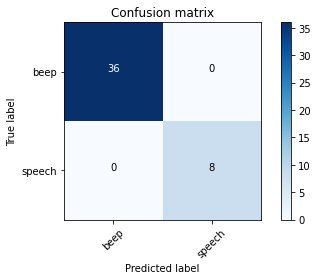

In [8]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
base_lr = LogisticRegression(solver='lbfgs', max_iter=4000)
ovr = OneVsRestClassifier(base_lr)
train(['mfccs_40'], ovr)

In [9]:
save_model(ovr,"ovr")

## RandomForest

total number of features 40
Score: 1.0
cross_val_scores: [1. 1. 1. 1. 1.]
Accuracy: 1.00 (+/- 0.00)
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00         8

   micro avg       1.00      1.00      1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44

[[36  0]
 [ 0  8]]

Confusion matrix, without normalization
[[36  0]
 [ 0  8]]
*** Scaled ***
scaled_model score: 1.0


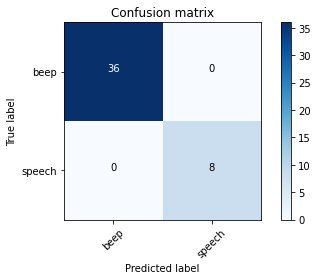

In [10]:
features_to_include = ['mfccs_40']
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 50)
rf = train(features_to_include, model)

In [11]:
#working model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rf = RandomForestClassifier(n_estimators = 100)
X = list(df.mfccs_40.values)
y = df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

fit_model = rf.fit(X_train, y_train)

In [12]:
save_model(fit_model,"rf")

## XGBoost

total number of features 40
[21:02:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score: 1.0
[21:02:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:02:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:02:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the de

/Users/sptm/.pyenv/versions/amd/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/sptm/.pyenv/versions/amd/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:02:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:02:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
cross_val_scores: [1.         1.         1.         1.         0.94871795]
Accuracy: 0.99 (+/- 0.04)
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00         8

   micro avg       1.00      1.00      1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



/Users/sptm/.pyenv/versions/amd/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
       gamma=0, gpu_id=-1, importance_type=None,
       interaction_constraints='', learning_rate=0.300000012,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
       monotone_constraints='()', n_estimators=100, n_jobs=16,
       num_parallel_tree=1, objective='binary:logistic', predictor='auto',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       subsample=1, tree_method='exact', use_label_encoder=True,
       validate_parameters=1, verbosity=None)

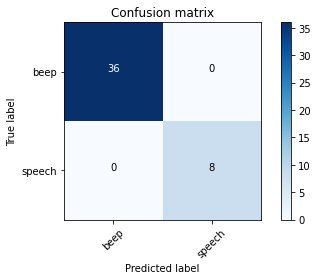

In [15]:
import xgboost as xgb

features_to_include = ['mfccs_40']
model = xgb.XGBClassifier()
train(features_to_include, model)

## LogisticRegression

total number of features 40
Score: 1.0
cross_val_scores: [1. 1. 1. 1. 1.]
Accuracy: 1.00 (+/- 0.00)
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00         8

   micro avg       1.00      1.00      1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44

[[36  0]
 [ 0  8]]

Confusion matrix, without normalization
[[36  0]
 [ 0  8]]
*** Scaled ***
scaled_model score: 1.0


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

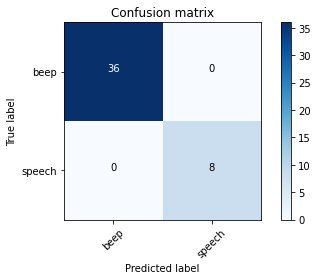

In [16]:
from sklearn.linear_model import LogisticRegression

features_to_include = ['mfccs_40']
logisticRegr = LogisticRegression(solver='liblinear', max_iter=200)
train(features_to_include, logisticRegr)

## SVM

total number of features 40
Score: 1.0
cross_val_scores: [1.         1.         0.94871795 1.         0.90225564]
Accuracy: 0.97 (+/- 0.08)
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00         8

   micro avg       1.00      1.00      1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44

[[36  0]
 [ 0  8]]

Confusion matrix, without normalization
[[36  0]
 [ 0  8]]
*** Scaled ***
scaled_model score: 1.0


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

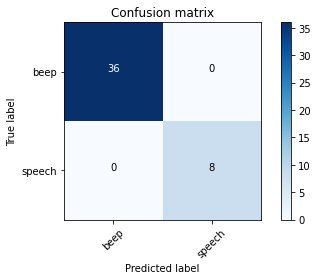

In [17]:
from sklearn import svm
svm = svm.SVC(gamma='scale')
features_to_include = ['mfccs_40']
train(features_to_include, svm)

#Save Model

In [18]:
import pickle
import datetime
filename = "rf-{}.pkl".format(datetime.datetime.now().strftime("%Y%m%dT%H%M"))
pickle.dump(rf, open(filename, 'wb'))